In [1]:
import datetime
import lightgbm
import numpy as np
import pandas as pd
from joblib import dump
from cucco import Cucco
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import text
from category_encoders import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = text.ENGLISH_STOP_WORDS.union(["incl"])
cucco = Cucco()
normalizations = [
    ('replace_punctuation', {'replacement': ' '}),
    ('replace_hyphens', {'replacement': ' '}),
    ('replace_symbols', {'replacement': ' '}),
    'remove_stop_words',
    'remove_extra_white_spaces'
]



In [2]:
df_train_clean = pd.read_csv('../data/train_data_cleaned.csv')
df_test_clean = pd.read_csv('../data/test_data_cleaned.csv')

In [3]:
df_train_clean['recipe_name'] = df_train_clean['recipe_name'].apply(lambda x: cucco.normalize(x, normalizations).lower())
df_test_clean['recipe_name'] = df_test_clean['recipe_name'].apply(lambda x: cucco.normalize(x, normalizations).lower())

df_train_clean.description = df_train_clean.description.fillna('')
df_test_clean.description = df_test_clean.description.fillna('')

df_train_clean['description'] = df_train_clean['description'].apply(lambda x: cucco.normalize(x, normalizations).lower())
df_test_clean['description'] = df_test_clean['description'].apply(lambda x: cucco.normalize(x, normalizations).lower())

df_train_clean = df_train_clean.drop(columns=['difficulty', 'protein_types'])
df_test_clean = df_test_clean.drop(columns=['difficulty', 'protein_types'])

In [4]:
CATEGORICAL_FEATURES = [
    "product_type",
    "dish_type",
    "protein_cuts",
    "heat_level",
    #"difficulty",
    "preferences",
]
NUMERICAL_FEATURES = [
    "proteins",
    "number_of_ingredients_per_recipe",
    "fat",
    "carbs",
    "calories",
    "n_products",
]
TEXT_FEATURES = [
    "recipe_name",
]
TAGS_FEATURES = [
    "meta_tags",
    "carbs_content",
    "dish_types",
]

CATEGORICAL_FEATURES = CATEGORICAL_FEATURES + ['cuisine', 'cooking_time'] 

In [5]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def estimate_sample_weights(df, n):
    return ((df.week_day - df.week_day.min()).dt.days + 1) ** n


def add_date(df):
    df["week_day"] = df.year_week.apply(
    lambda year_week: datetime.datetime.strptime(str(year_week) + "-1", "%G%V-%u")
    )

    df[TAGS_FEATURES + ["dish_type"]] = df[TAGS_FEATURES + ["dish_type"]].fillna("unk")
    df = df.merge(
        (df
            .groupby("year_week")
            .agg({"recipe_id": "count"})
            .rename(columns={"recipe_id": "n_products"})
        ),
        how="left",
        left_on="year_week",
        right_index=True,
    )

    weekdays = sorted(df["week_day"].unique())
    assert len(np.unique(np.diff(weekdays))) == 1

    return df

In [6]:
model = Pipeline([
    ("feature_preprocessor", ColumnTransformer([
        ("categorical", OrdinalEncoder(handle_missing="return_nan"), CATEGORICAL_FEATURES),
        ("numerical", MinMaxScaler(), NUMERICAL_FEATURES),

        ("recipe_name_tfidf", TfidfVectorizer(min_df=20), 
                                              "recipe_name"),
        ("description_tfidf", TfidfVectorizer(min_df=20, 
                                              stop_words=stop_words, 
                                              ngram_range=(1,2)), 
                                              "description"),

        ("meta_tags_tfidf", TfidfVectorizer(min_df=20, 
                                            token_pattern='[^,\s]+', 
                                            stop_words=stop_words, 
                                            ngram_range=(1,2)), 
                                            "meta_tags"),

        ("carbs_content_tfidf", TfidfVectorizer(min_df=20, 
                                                token_pattern='[^_\s]+', 
                                                stop_words=stop_words, 
                                                ngram_range=(1,2)), 
                                                "carbs_content"),
    ])),
    
    ("regressor", lightgbm.LGBMRegressor(
        n_estimators=50,
        objective="regression",
        num_leaves=10,
        max_depth=4,
        min_child_samples=60,
        learning_rate=0.09,
        colsample_bytree=0.6,
        verbosity=-1,
        extra_trees=True,
        metric="rmse"
    )),
])

In [7]:
df_train_clean = add_date(df_train_clean)
df_test_clean = add_date(df_test_clean)

In [8]:
year_weeks = sorted(df_train_clean.year_week.unique())

errors = []
n_folds = 5
n_of_weeks_to_predict = 5

for fold in range(n_folds):
    print(f"Running CV on fold {fold + 1} / {n_folds}")
    week_start = year_weeks[-(fold + 1) * n_of_weeks_to_predict]
    week_end = year_weeks[-fold * n_of_weeks_to_predict - 1]

    print(f"  Running validation on weeks {week_start} - {week_end}")

    df_train = df_train_clean[df_train_clean.year_week < week_start]
    df_val = df_train_clean[(df_train_clean.year_week >= week_start) & (df_train_clean.year_week <= week_end)]

    print(f"  Number of training samples: {len(df_train)}")
    print(f"  Number of validation samples: {len(df_val)}")

    assert len(df_val.year_week.unique()) == n_of_weeks_to_predict

    df_train_features = df_train.drop(columns=['sales'])
    df_val_features = df_val.drop(columns=['sales'])

    print("  Training the model...")
    model.fit(df_train_features, df_train.sales, regressor__sample_weight=estimate_sample_weights(df_train_features, 4))
    y_predicted = np.clip(model.predict(df_val_features), 0, np.inf).astype(int)
    error = rmse(df_val.sales, y_predicted)

    print(f"  RMSE: {error:.2f}")
    errors.append(error)

print(f"Average RMSE accross {n_folds} folds: {np.mean(errors):.2f}")

Running CV on fold 1 / 5
  Running validation on weeks 201940 - 201944
  Number of training samples: 2737
  Number of validation samples: 202
  Training the model...
  RMSE: 2978.66
Running CV on fold 2 / 5
  Running validation on weeks 201935 - 201939
  Number of training samples: 2531
  Number of validation samples: 206
  Training the model...
  RMSE: 3147.92
Running CV on fold 3 / 5
  Running validation on weeks 201930 - 201934
  Number of training samples: 2331
  Number of validation samples: 200
  Training the model...
  RMSE: 2857.22
Running CV on fold 4 / 5
  Running validation on weeks 201925 - 201929
  Number of training samples: 2131
  Number of validation samples: 200
  Training the model...
  RMSE: 3154.87
Running CV on fold 5 / 5
  Running validation on weeks 201920 - 201924
  Number of training samples: 1931
  Number of validation samples: 200
  Training the model...
  RMSE: 3335.56
Average RMSE accross 5 folds: 3094.84


In [9]:
print("Training the model on all training data...")
df_train_features = df_train_clean.drop(columns=['sales'])
model.fit(df_train_features, df_train_clean.sales, regressor__sample_weight=estimate_sample_weights(df_train_features, 4))

print("Saving trained production model...")
dump(model, '../model/model')
print(f"Saved")

Training the model on all training data...
Saving trained production model...
Saved


In [10]:
print("Generating predictions for the test data...")
df_test_clean = df_test_clean.drop(columns=['sales'])
y_predicted = np.clip(model.predict(df_test_clean), 0, np.inf).astype(int)
df_test_results = pd.DataFrame({
    "recipe_id": df_test_clean.recipe_id,
    "year_week": df_test_clean.year_week,
    "predicted_sales": y_predicted,
})
df_test_results.to_csv('../data/results.csv', index=None)
print(f"Saved predictions")

Generating predictions for the test data...
Saved predictions


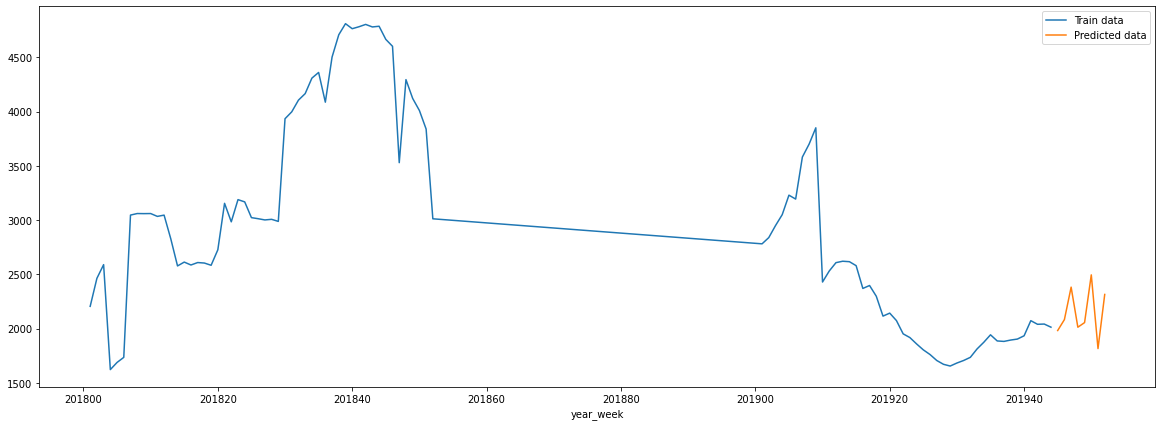

In [11]:
test_data = pd.read_csv('../data/results.csv')
rcParams['figure.figsize'] = 20, 7
axis = df_train_clean.groupby(["year_week"]).sales.mean().plot()
test_data.groupby(["year_week"]).predicted_sales.mean().plot(ax=axis)
plt.legend(['Train data', 'Predicted data'])